In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Keras importok az órai anyagok stílusában
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import Xception, EfficientNetB0 # Használhatjuk az Xceptiont (Class 17) vagy EfficientNet-et

# Sklearn a felosztáshoz
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Képkezelés
from PIL import Image

# Beállítások
IMG_SIZE = (224, 224) # Vagy 299 az Xception-höz
BATCH_SIZE = 32
RANDOM_SEED = 42

print("Könyvtárak sikeresen betöltve.")

Könyvtárak sikeresen betöltve.


In [6]:
# --- 1. ADATOK BETÖLTÉSE ---
df = pd.read_csv('metadata.csv')

# Útvonal beállítása (Ezt az egyet módosítsd, ha másik gépen futtatod!)
data_root_path = r'C:\Users\Balázs\Downloads\rare_species' 
df['full_path'] = df['file_path'].apply(lambda x: os.path.join(data_root_path, x))

# --- 2. TISZTÍTÁS (A te kódod alapján) ---
# Hiányzó adatok eldobása
df = df.dropna(subset=['file_path', 'family']).reset_index(drop=True)

# Fájlok ellenőrzése (csak a létezőket tartjuk meg)
# Ez lassú lehet, ha sok a kép, de biztonságos
df['exists'] = df['full_path'].apply(os.path.exists)
print(f"Hiányzó fájlok száma: {len(df[df['exists'] == False])}")
df = df[df['exists'] == True].reset_index(drop=True)

# Duplikátumok eltávolítása
df = df.drop_duplicates().reset_index(drop=True)
df = df.drop_duplicates(subset='full_path').reset_index(drop=True)

print(f"Tisztított adathalmaz mérete: {len(df)} kép")
print(f"Kategóriák (családok) száma: {df['family'].nunique()}")

# Célváltozó (family) string típusú legyen a Keras flow_from_dataframe miatt
df['family'] = df['family'].astype(str)

Hiányzó fájlok száma: 0
Tisztított adathalmaz mérete: 11983 kép
Kategóriák (családok) száma: 202


In [7]:
# Először leválasztjuk a Teszt halmazt (15%)
train_val_df, test_df = train_test_split(
    df, 
    test_size=0.15, 
    stratify=df['family'], 
    random_state=RANDOM_SEED
)

# A maradékból leválasztjuk a Validációs halmazt
# (A maradék 85%-nak a 17.65%-a kb. az eredeti 15%-a)
train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.1765, 
    stratify=train_val_df['family'], 
    random_state=RANDOM_SEED
)

print(f"Train méret: {len(train_df)}")
print(f"Val méret:   {len(val_df)}")
print(f"Test méret:  {len(test_df)}")

Train méret: 8387
Val méret:   1798
Test méret:  1798


In [8]:
# Kiszámoljuk, melyik osztály mennyire ritka
unique_families = np.unique(train_df['family'])
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_families,
    y=train_df['family']
)

# Szótárba rendezzük, amit a Keras megért
class_weights_dict = dict(zip(range(len(unique_families)), class_weights))

print("Osztálysúlyok kiszámolva. (A ritka fajok nagyobb súlyt kapnak a tanításnál).")

Osztálysúlyok kiszámolva. (A ritka fajok nagyobb súlyt kapnak a tanításnál).


In [9]:
# Ha Xception-t használsz (mint a 17. órán), akkor:
# from tensorflow.keras.applications.xception import preprocess_input
# Ha EfficientNet-et (ajánlott), akkor:
from tensorflow.keras.applications.efficientnet import preprocess_input

# 1. Training Generator (Adatdúsítással/Augmentation-nel)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Fontos a Transfer Learninghez!
    rotation_range=20,
    width_shift_range=0.2,  
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Validation/Test Generator (Csak preprocess, nincs torzítás)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("Generatorok inicializálva. Adatok betöltése...")

# Train Flow
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Val Flow
val_ds = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

# Test Flow
test_ds = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Generatorok inicializálva. Adatok betöltése...
Found 8387 validated image filenames belonging to 202 classes.
Found 1798 validated image filenames belonging to 202 classes.
Found 1798 validated image filenames belonging to 202 classes.


In [10]:
def build_model(num_classes):
    # 1. Alapmodell betöltése (ImageNet súlyokkal, fej nélkül)
    # A 17. órán Xception volt, de az EfficientNetB0 gyorsabb és pontosabb
    base_model = EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    
    # Lefagyasztjuk az alapmodellt, hogy ne rontsuk el a tanult súlyokat
    base_model.trainable = False

    # 2. Saját "fej" (Head) hozzáadása
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Vagy Flatten(), ahogy a 16. órán volt, de ez jobb
    x = Dropout(0.3)(x)             # Overfitting ellen
    x = Dense(256, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Teljes modell összeállítása
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Modell létrehozása
num_classes = len(train_ds.class_indices)
model, base_model = build_model(num_classes)

# Fordítás (Compile)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 13s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,429,421 (16.90 MB)

 Trainable params: 379,850 (1.45 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
# Callbackek beállítása (hogy ne fusson feleslegesen sokáig)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_phase1.h5', monitor='val_accuracy', save_best_only=True)

print("Fázis 1: Csak a felső rétegek tanítása...")

history_1 = model.fit(
    train_ds,
    epochs=10,  # Kezdetnek elég
    validation_data=val_ds,
    class_weight=class_weights_dict, # Itt használjuk a súlyozást az egyensúlyhiány miatt
    callbacks=[early_stop, checkpoint]
)

Fázis 1: Csak a felső rétegek tanítása...
Epoch 1/10
226/263 ━━━━━━━━━━━━━━━━━━━━ 1:41 3s/step - accuracy: 0.1155 - loss: 4.7294

c:\Users\Balázs\Documents\NOVA\DL\Deep-Learning-project\venv\Lib\site-packages\PIL\Image.py:3432: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1313 - loss: 4.6043

263/263 ━━━━━━━━━━━━━━━━━━━━ 857s 3s/step - accuracy: 0.2382 - loss: 3.7520 - val_accuracy: 0.4588 - val_loss: 2.3067
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4801 - loss: 1.8867

263/263 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.4869 - loss: 1.8420 - val_accuracy: 0.5328 - val_loss: 1.8863
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5922 - loss: 1.3559

263/263 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.5830 - loss: 1.3826 - val_accuracy: 0.5740 - val_loss: 1.6963
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6443 - loss: 1.0818

263/263 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.6411 - loss: 1.1062 - val_accuracy: 0.6029 - val_loss: 1.5695
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6814 - loss: 0.9244

263/263 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.6790 - loss: 0.9529 - val_accuracy: 0.6218 - val_loss: 1.5019
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.7030 - loss: 0.8373 - val_accuracy: 0.6168 - val_loss: 1.5412
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.7186 - loss: 0.7576 - val_accuracy: 0.6212 - val_loss: 1.4657
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7552 - loss: 0.6323

263/263 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.7437 - loss: 0.6708 - val_accuracy: 0.6390 - val_loss: 1.4678
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - accuracy: 0.7605 - loss: 0.6096 - val_accuracy: 0.6374 - val_loss: 1.4452
Epoch 10/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7853 - loss: 0.5335

263/263 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.7737 - loss: 0.5640 - val_accuracy: 0.6479 - val_loss: 1.4217


In [12]:
print("Fázis 2: Finomhangolás (Fine-tuning)...")

# Kiolvasztjuk az alapmodellt
base_model.trainable = True

# De csak az utolsó 20-30 réteget hagyjuk nyitva, a többit visszazárjuk
# (Az EfficientNetB0 kb 230 rétegű)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Újrafordítás KIS tanulási rátával (nagyon fontos!)
model.compile(
    optimizer=Adam(learning_rate=1e-5), # 100x kisebb learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tanítás folytatása
history_2 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    class_weight=class_weights_dict,
    callbacks=[early_stop, ModelCheckpoint('best_model_final.h5', save_best_only=True)]
)

Fázis 2: Finomhangolás (Fine-tuning)...
Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7239 - loss: 0.9036

263/263 ━━━━━━━━━━━━━━━━━━━━ 704s 3s/step - accuracy: 0.7240 - loss: 0.8990 - val_accuracy: 0.6235 - val_loss: 1.4822
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7385 - loss: 0.8167

263/263 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.7431 - loss: 0.7938 - val_accuracy: 0.6290 - val_loss: 1.4797
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7561 - loss: 0.7511

263/263 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.7563 - loss: 0.7470 - val_accuracy: 0.6335 - val_loss: 1.4535
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7616 - loss: 0.6879

263/263 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.7650 - loss: 0.6809 - val_accuracy: 0.6335 - val_loss: 1.4387
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7764 - loss: 0.6494

263/263 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.7775 - loss: 0.6360 - val_accuracy: 0.6352 - val_loss: 1.4238


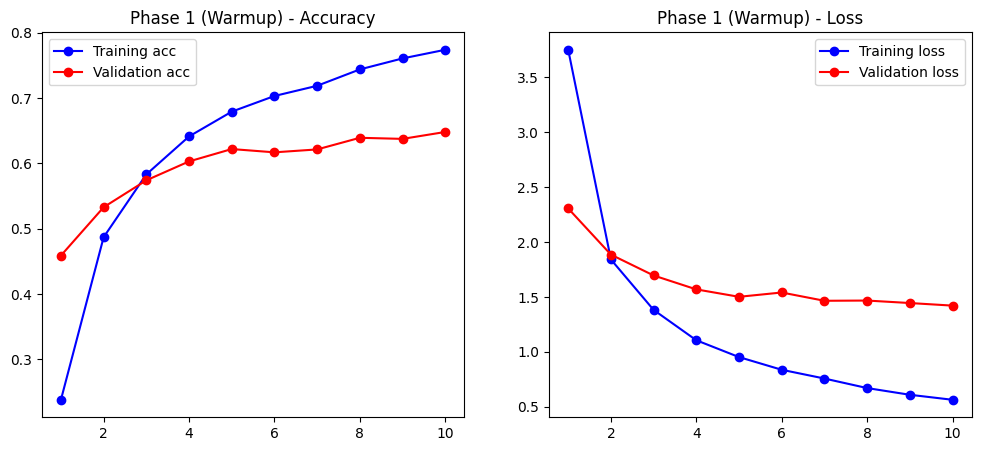

In [13]:
def plot_history(hist, phase_name):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{phase_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{phase_name} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_1, "Phase 1 (Warmup)")
# Ha lefutott a 2. fázis:
# plot_history(history_2, "Phase 2 (Fine-tuning)")

In [14]:
import tensorflow as tf

# Ellenőrizzük, hogy látja-e a rendszer a GPU-t
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU elérhető: {gpus}")
else:
    print("Csak CPU elérhető.")

Csak CPU elérhető.
